/tmp/ipykernel_100551/233726200.py:42: RuntimeWarning: divide by zero encountered in divide
  H = 1 / (1 + (cutoff / D)**(2 * n))
/tmp/ipykernel_100551/233726200.py:45: RuntimeWarning: divide by zero encountered in divide
  H = 1 / (1 + ((D * (D**2 - D0 * D1)) / ((D**2 - D0**2) * (D**2 - D1**2)))**(2 * n))


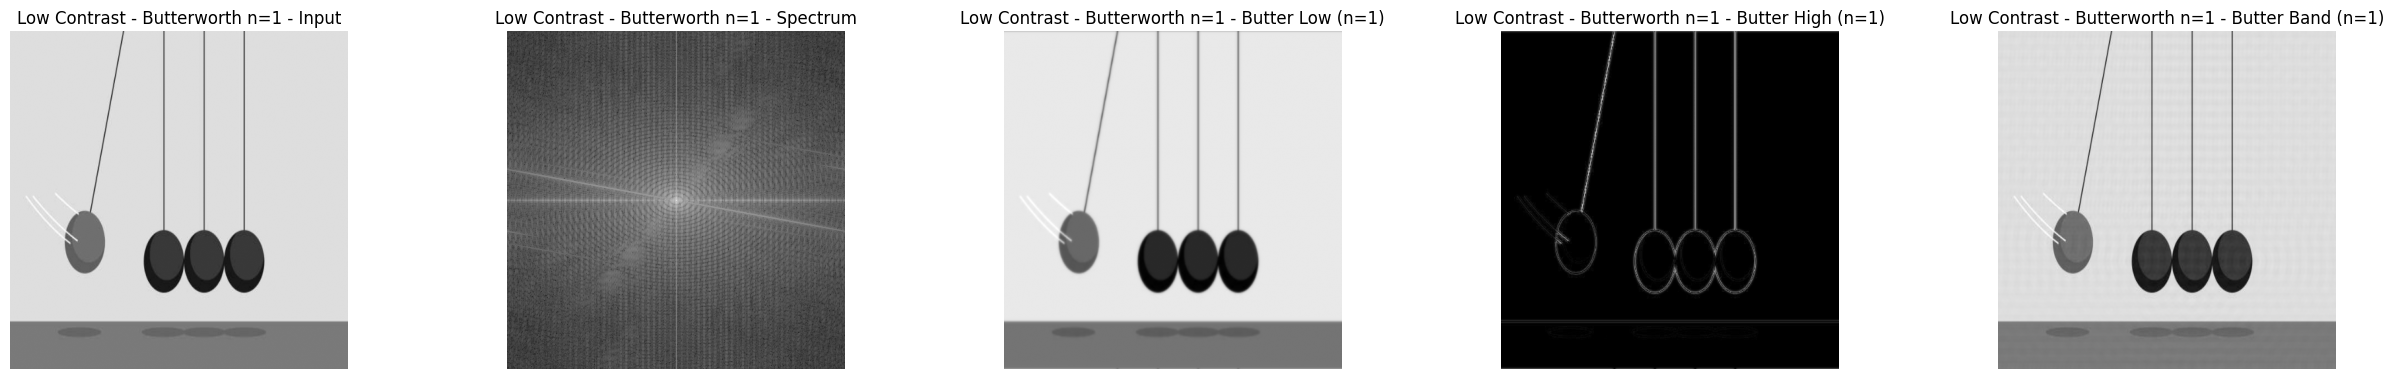

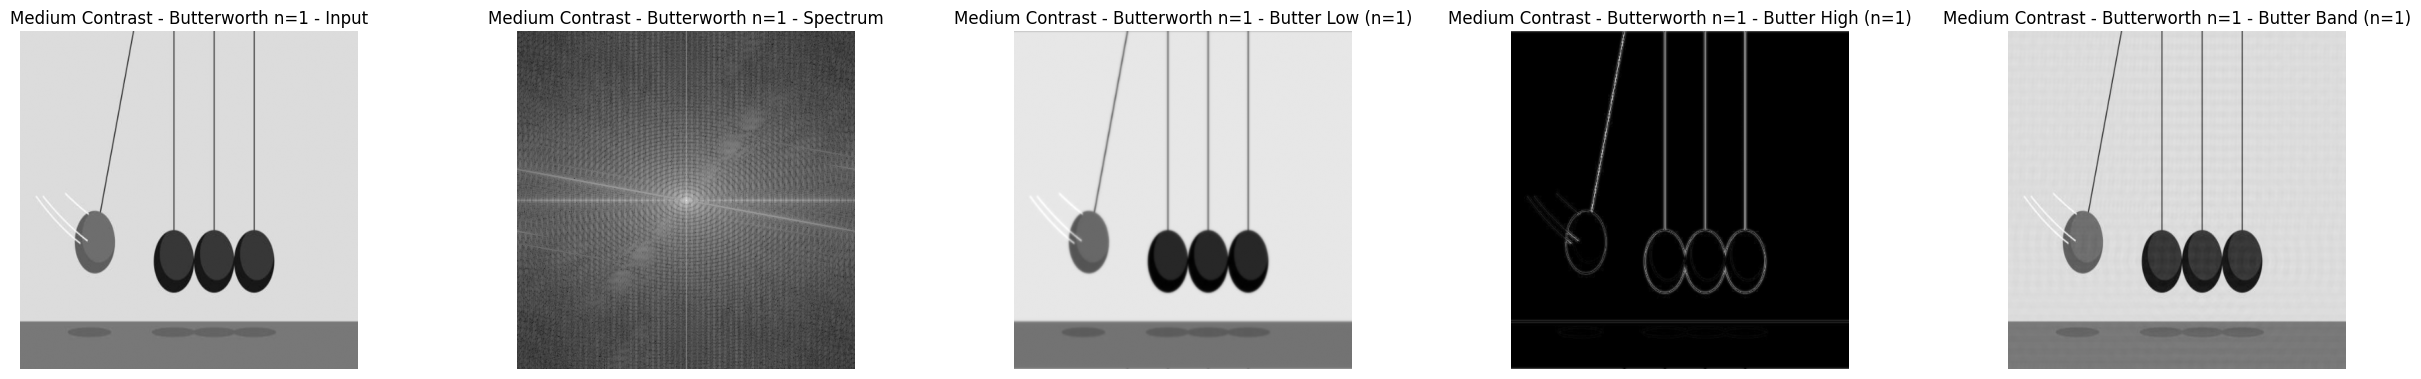

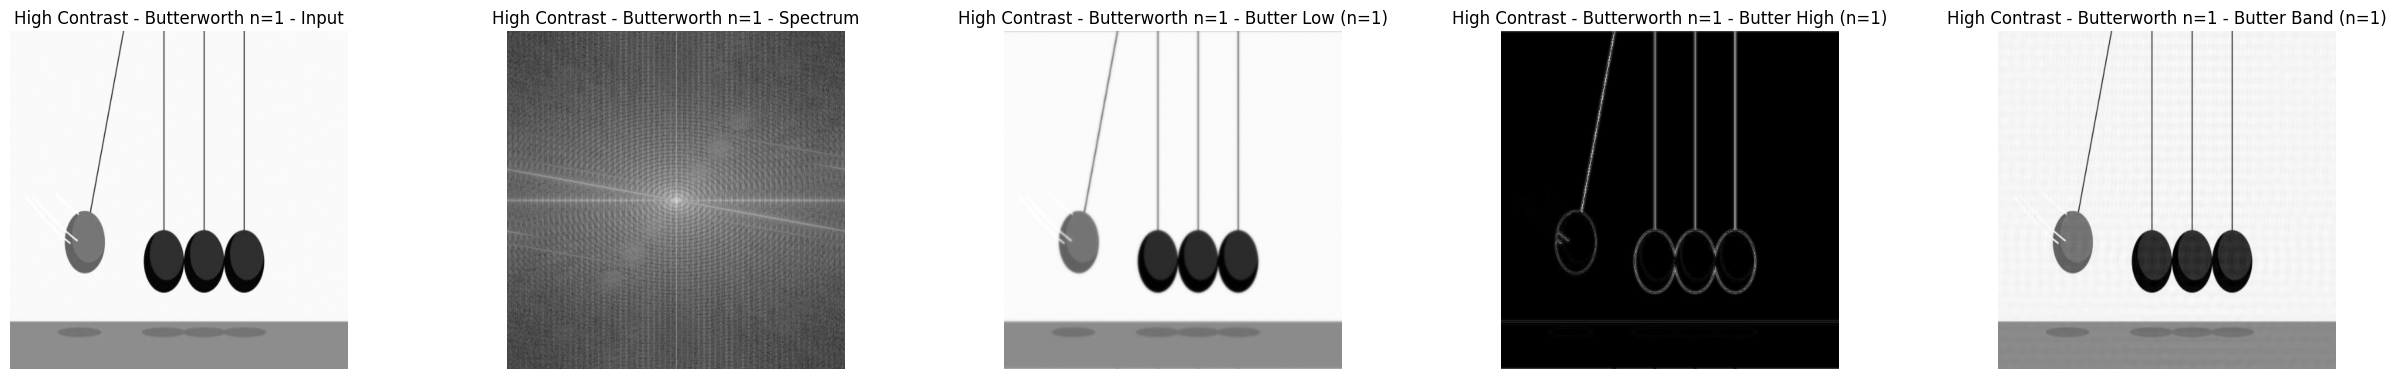

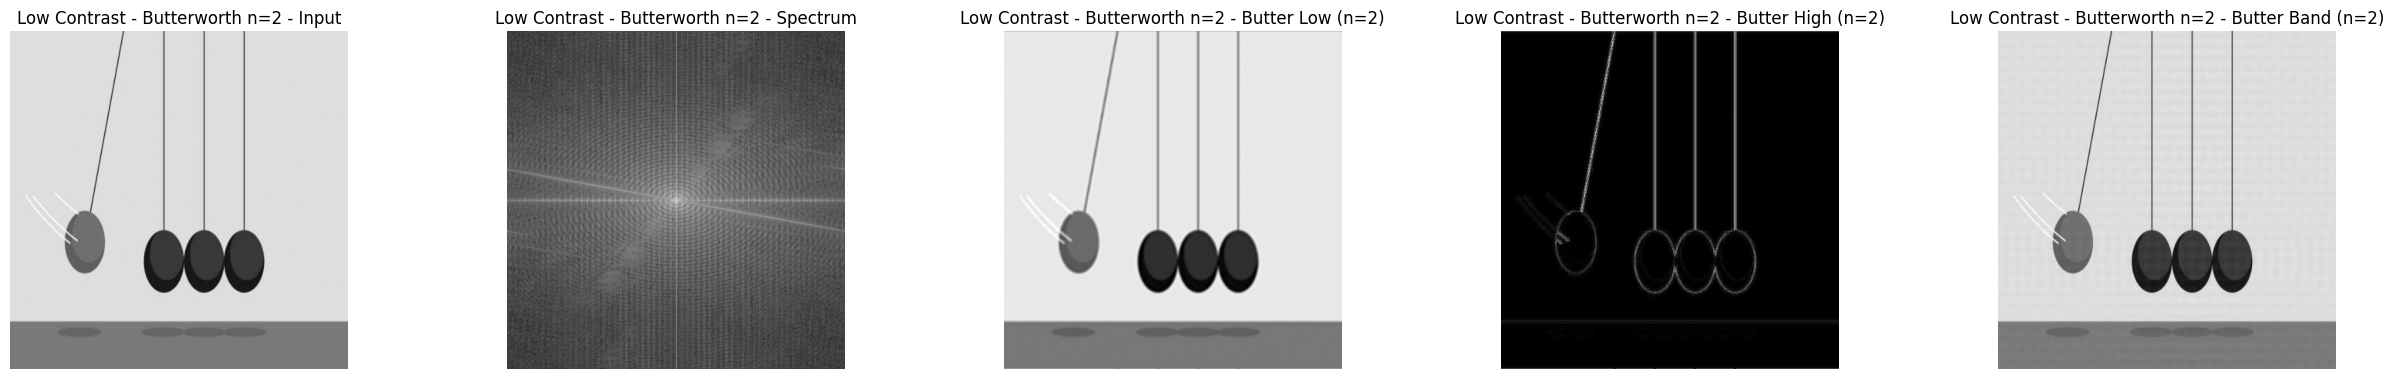

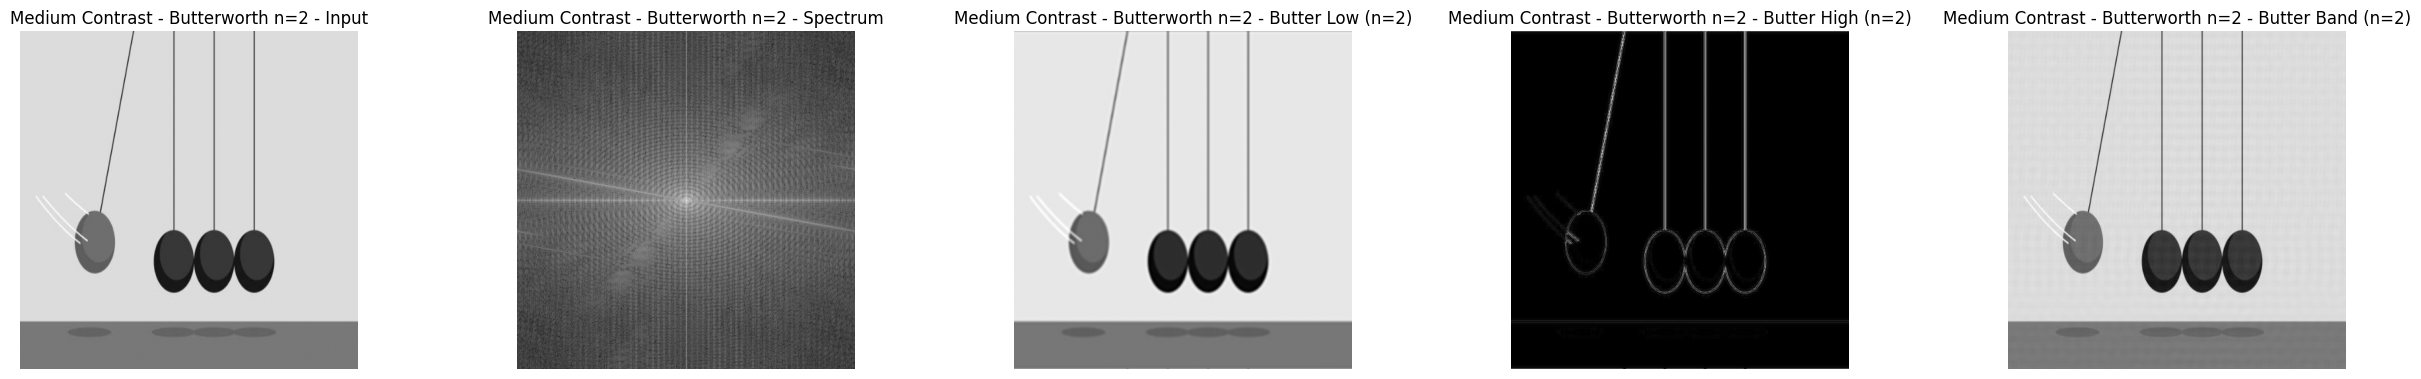

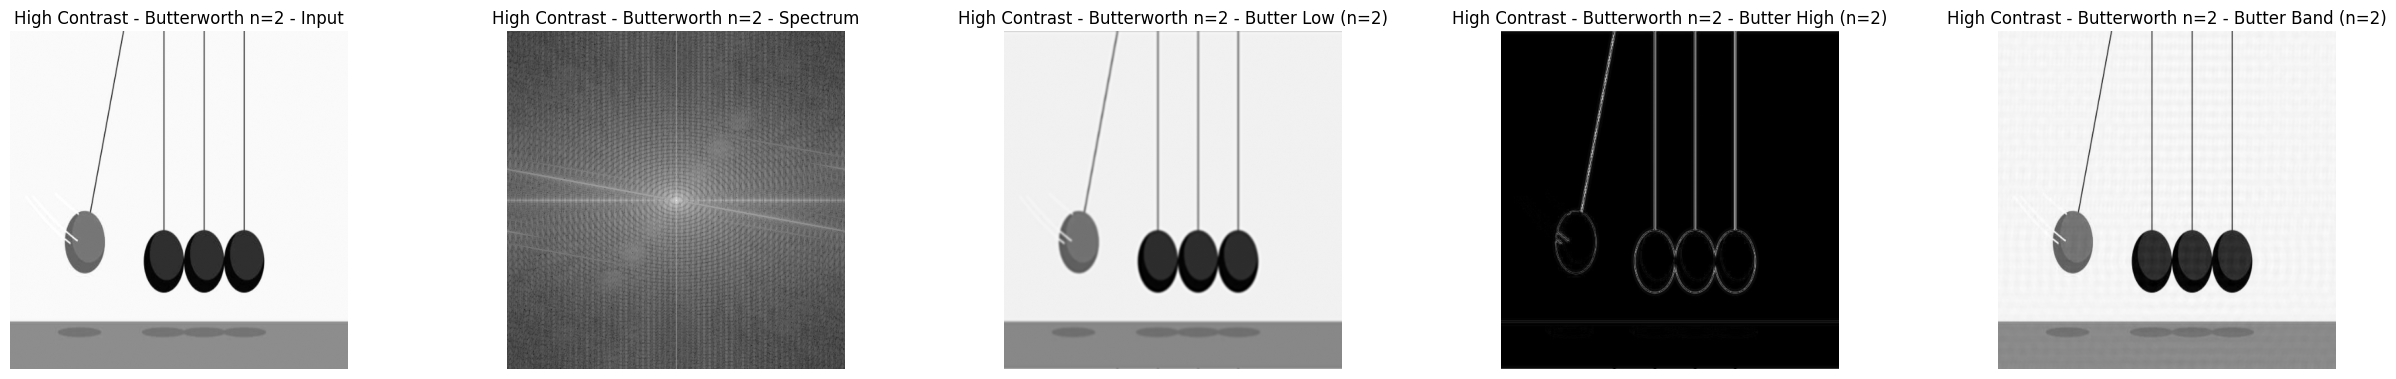

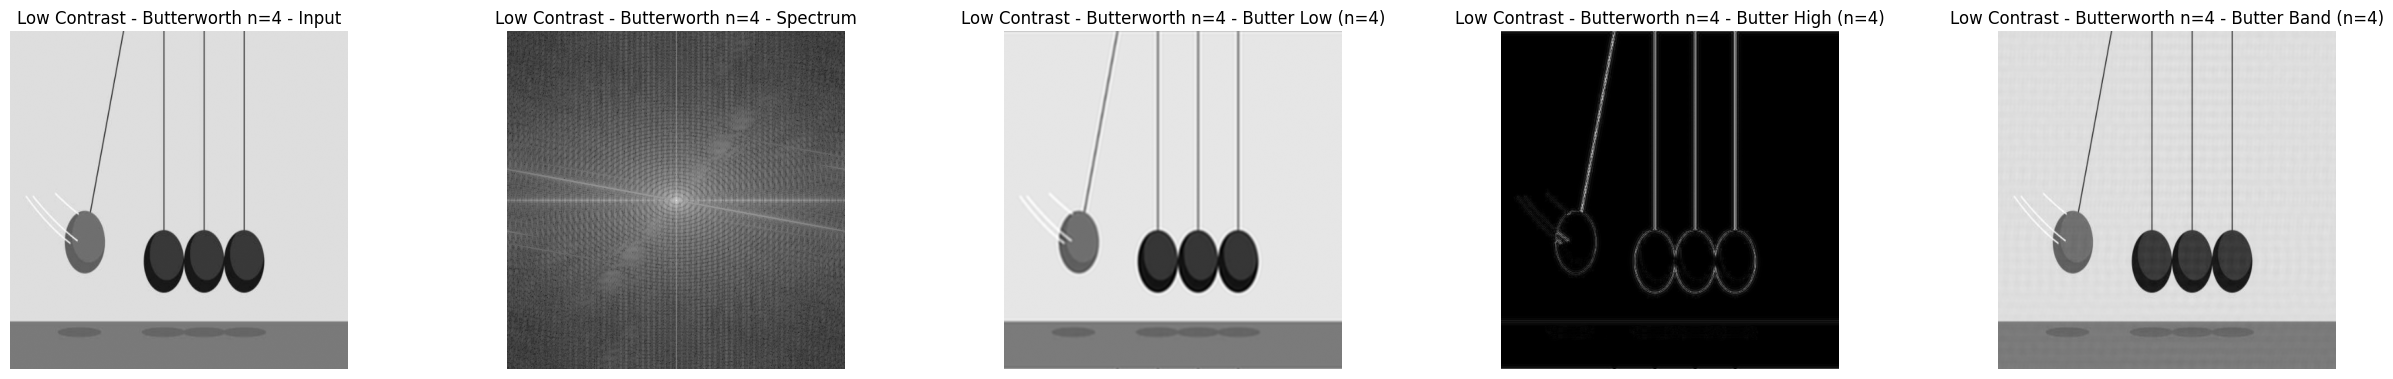

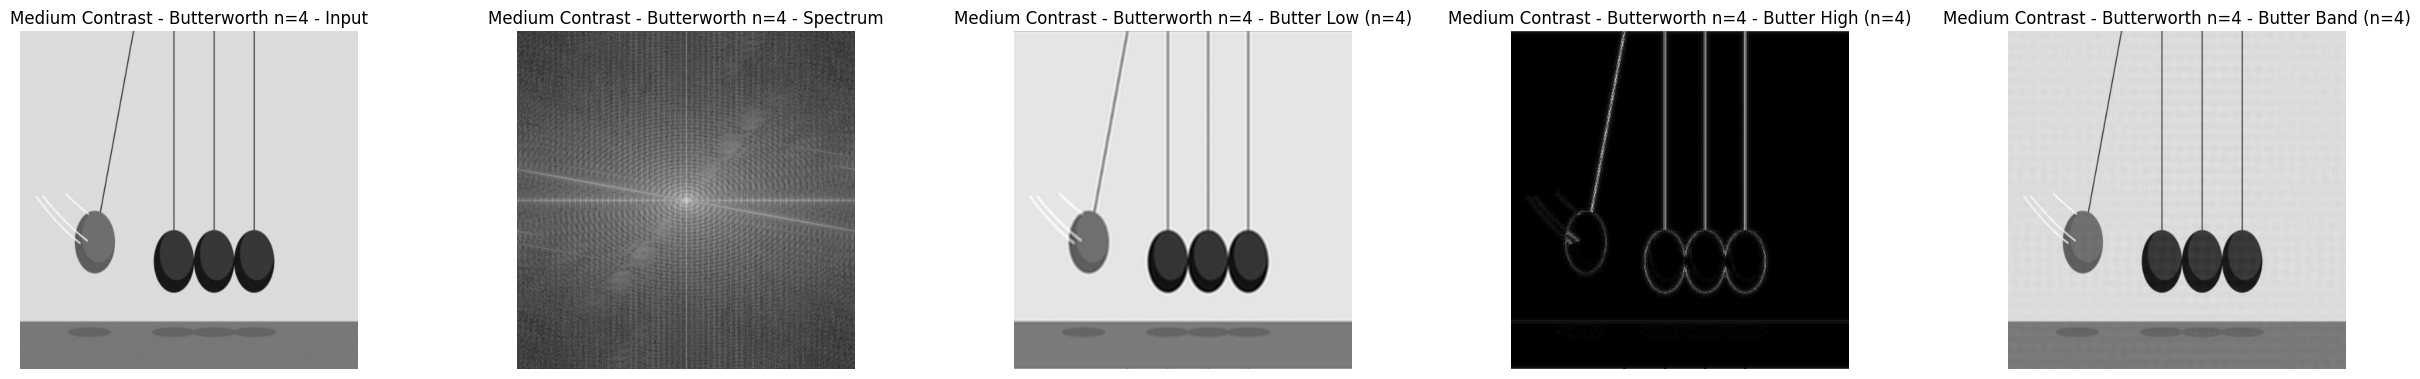

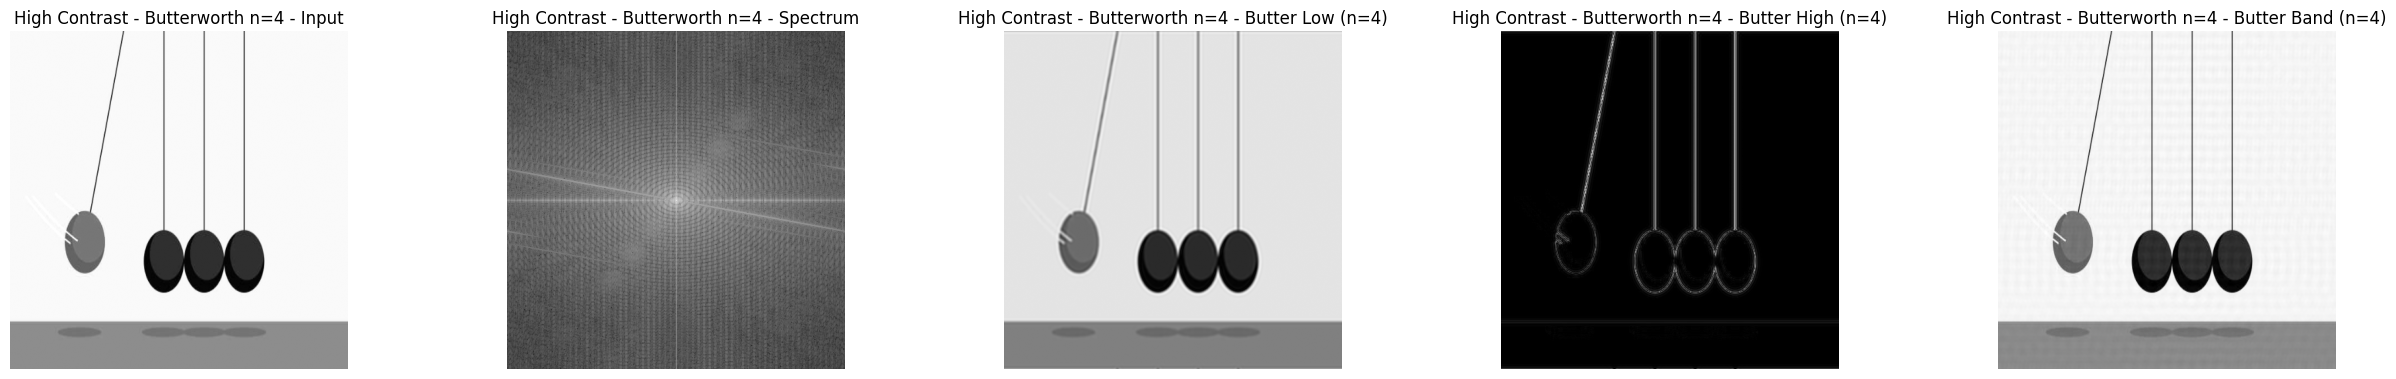

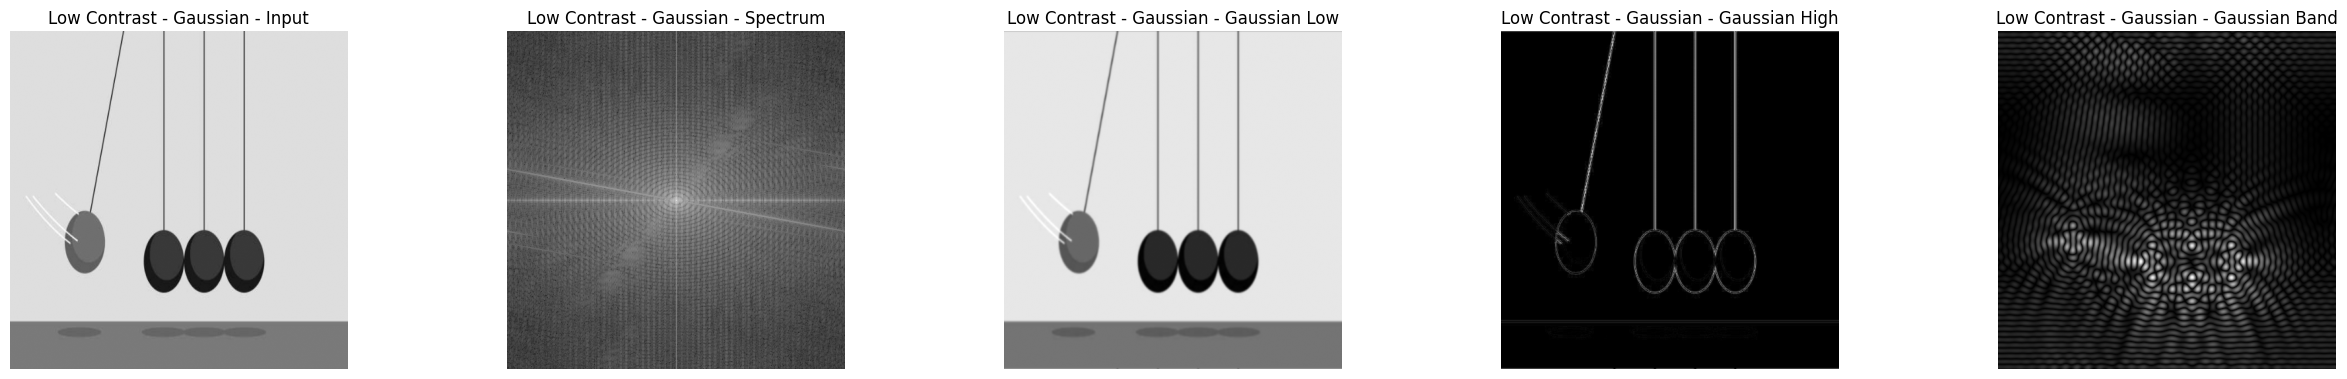

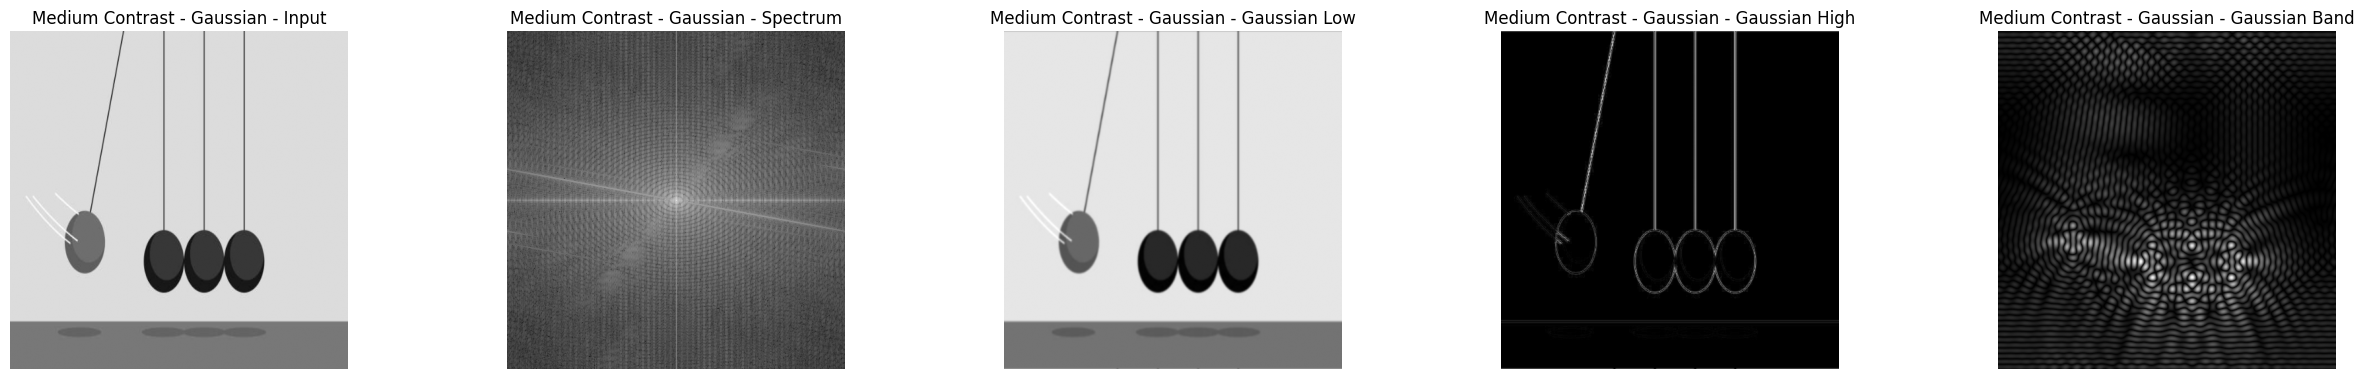

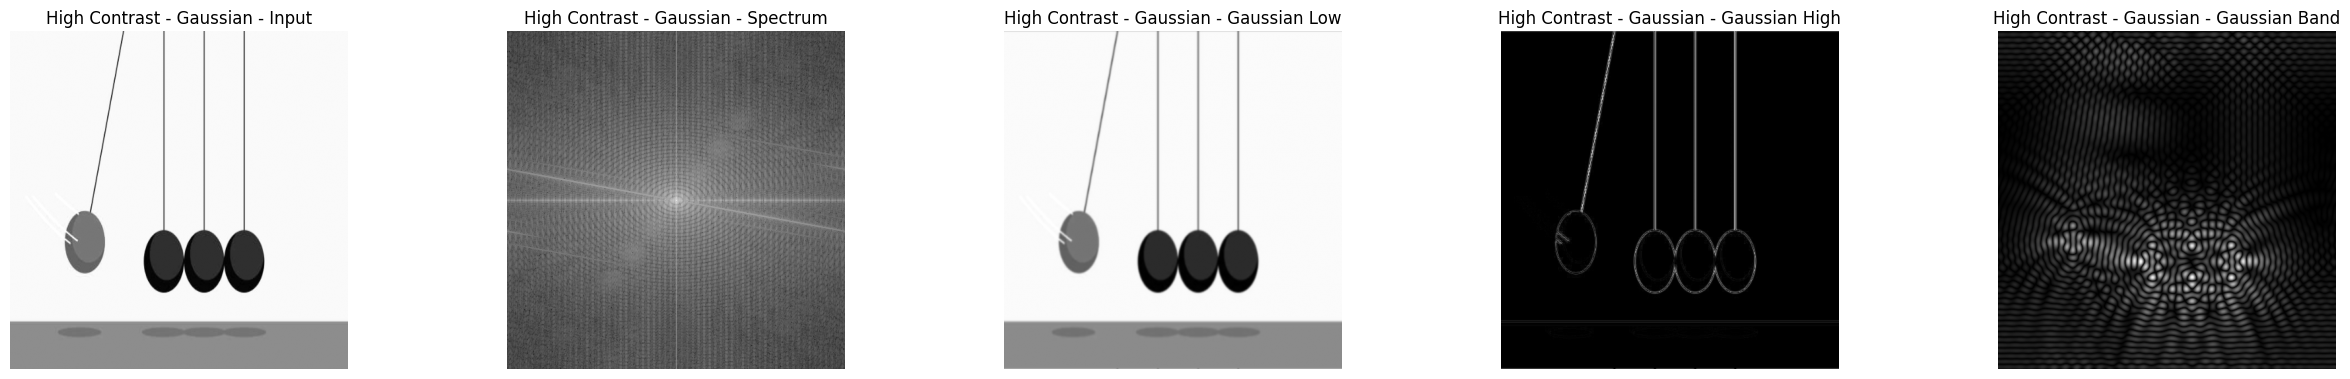

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

r, c = 5, 5
cnt = 0

def show(img, title):
    global cnt
    cnt += 1
    img = np.abs(img)
    img = (img - np.min(img)) / (np.max(img) - np.min(img))  # normalize
    plt.subplot(r, c, cnt)
    plt.imshow(img, cmap='gray')
    plt.title(title)
    plt.axis('off')


def load_image(path):
    img = cv2.imread(path, 0)
    img = cv2.resize(img, (512, 512))
    return img


def build_frequency(image):
    f = np.fft.fft2(image)
    return np.fft.fftshift(f)


def butterworth_filter(shape, cutoff, n, type='low'):
    rows, cols = shape
    crow, ccol = rows // 2, cols // 2
    u = np.arange(rows)
    v = np.arange(cols)
    U, V = np.meshgrid(u, v, indexing='ij')
    D = np.sqrt((U - crow)**2 + (V - ccol)**2)

    if type == 'low':
        H = 1 / (1 + (D / cutoff)**(2 * n))
    elif type == 'high':
        H = 1 / (1 + (cutoff / D)**(2 * n))
    elif type == 'band':
        D0, D1 = cutoff
        H = 1 / (1 + ((D * (D**2 - D0 * D1)) / ((D**2 - D0**2) * (D**2 - D1**2)))**(2 * n))
    return H

def gaussian_filter(shape, cutoff, type='low'):
    rows, cols = shape
    crow, ccol = rows // 2, cols // 2
    u = np.arange(rows)
    v = np.arange(cols)
    U, V = np.meshgrid(u, v, indexing='ij')
    D = np.sqrt((U - crow)**2 + (V - ccol)**2)

    if type == 'low':
        H = np.exp(-(D**2) / (2 * (cutoff**2)))
    elif type == 'high':
        H = 1 - np.exp(-(D**2) / (2 * (cutoff**2)))
    elif type == 'band':
        D0, D1 = cutoff
        H = np.exp(-(D**2 - D0**2)**2 / (2 * (D1**2)))
    return H


def apply_filter(img, filters, title_prefix):
    show(img, f"{title_prefix} - Input")
    dft_shift = build_frequency(img)
    show(10 * np.log(np.abs(dft_shift)), f"{title_prefix} - Spectrum")

    for name, mask in filters.items():
        fshift = dft_shift * mask
        f_ishift = np.fft.ifftshift(fshift)
        img_back = np.fft.ifft2(f_ishift)
        show(img_back, f"{title_prefix} - {name}")


def process_image(img, filter_sets, title_prefix):
    plt.figure(figsize=(25, 18))
    apply_filter(img, filter_sets, title_prefix)
    plt.tight_layout()
    plt.show()
    global cnt
    cnt = 0

def main():
    
    img_low = load_image("Image/low_contrast/1image.jpg")
    img_med = load_image("Image/medium_contrast/image1.jpg")
    img_high = load_image("Image/high_contrast/1image.jpg")

    shape = img_low.shape

  
    butter_orders = [1, 2, 4]
    for n in butter_orders:
        butter = {
            f'Butter Low (n={n})': butterworth_filter(shape, 80, n, 'low'),
            f'Butter High (n={n})': butterworth_filter(shape, 80, n, 'high'),
            f'Butter Band (n={n})': butterworth_filter(shape, (30, 80), n, 'band')
        }

        process_image(img_low, butter, f"Low Contrast - Butterworth n={n}")
        process_image(img_med, butter, f"Medium Contrast - Butterworth n={n}")
        process_image(img_high, butter, f"High Contrast - Butterworth n={n}")


    gaussian = {
        'Gaussian Low': gaussian_filter(shape, 80, 'low'),
        'Gaussian High': gaussian_filter(shape, 80, 'high'),
        'Gaussian Band': gaussian_filter(shape, (30, 80), 'band')
    }

    process_image(img_low, gaussian, "Low Contrast - Gaussian")
    process_image(img_med, gaussian, "Medium Contrast - Gaussian")
    process_image(img_high, gaussian, "High Contrast - Gaussian")

if __name__ == "__main__":
    main()
